### Zero-Shot Image Classification Using Diffusion Models (Text-to-Image GenAI)

##### Setup & Imports

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from diffusers import StableDiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from scipy.stats import ttest_rel
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

We collect one image for each of the 10 classes from the CIFAR-10 dataset to use as a small sample for testing the zero-shot classification task. The images are loaded from the datasets library and transformed into tensors using `transforms`. In addition to normalizing them to the range `[-1, 1]`, the images are resized to match the input size requirements of the latent diffusion model. This ensures compatibility with the VAE encoder of the model, which typically expects larger images like `512x512`. These preprocessed images will later be used for testing the zero-shot classification using the latent diffusion model.

In [4]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

class_images = {}
num_classes = 10
class_names = dataset.classes

torch.manual_seed(42)

for img, label in dataset:
    if label not in class_images:
        class_images[label] = img
    if len(class_images) == num_classes:
        break

images = [class_images[i] for i in range(num_classes)]
labels = [class_names[i] for i in range(num_classes)]

for idx, label in enumerate(labels):
    print(f"Image {idx+1}: {label}")


100%|██████████| 170498071/170498071 [01:36<00:00, 1768232.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Image 1: airplane
Image 2: automobile
Image 3: bird
Image 4: cat
Image 5: deer
Image 6: dog
Image 7: frog
Image 8: horse
Image 9: ship
Image 10: truck


#### Stable Diffusion Pipeline Setup & Image Preprocessing

We select one image from our preprocessed sample (the image of an airplane) to test the zero-shot classification. The Stable Diffusion pipeline is initialized using `CompVis/stable-diffusion-v1-4` with half-precision (16-bit floating point) tensors to optimize memory usage. The pipeline is moved to the GPU for faster computation. Since we have already resized and normalized our images during data ingestion, the preprocessing function will primarily add the batch dimension and move the tensor to the GPU. This processed image will be used as input to the VAE encoder of the latent diffusion model.

In [6]:
def setup_pipeline():
    pipe = StableDiffusionPipeline.from_pretrained(
        "CompVis/stable-diffusion-v1-4",
        torch_dtype=torch.float16
    )
    pipe = pipe.to("cuda")
    return pipe

def preprocess_image(image_tensor):
    processed_img = image_tensor.unsqueeze(0).to("cuda")
    return processed_img

input_image = images[0]
input_label = labels[0]

pipe = setup_pipeline()
processed_image = preprocess_image(input_image)

print(f"Input image shape after preprocessing: {processed_image.shape}")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Input image shape after preprocessing: torch.Size([1, 3, 512, 512])


In [26]:
input_label

'airplane'

#### Encoding Preprocessed Input to Latent Space $Z$

We define the `encode_image` function to convert the preprocessed input image tensor into its representation in the lower-dimensional latent space $Z$ using the Variational Autoencoder (VAE) from the Stable Diffusion pipeline. The VAE encoder produces a latent distribution from which we sample latent codes. These codes are then scaled using the VAE's scaling factor to match the expected input range of the diffusion model. This latent representation will be used in the subsequent steps of the diffusion process for zero-shot classification. In the output of the following cell, we observe a reduction in the spatial dimensions `(H, W)` of tensor from `[512,512]` to `[64, 64]`

In [19]:
def encode_image(image_tensor, pipeline):
    image_tensor = image_tensor.to(pipeline.vae.dtype)
    with torch.no_grad():
        latent_distribution = pipeline.vae.encode(image_tensor).latent_dist
        latent_codes = latent_distribution.sample()
        latent_codes *= pipeline.vae.config.scaling_factor
    return latent_codes

latent_representation = encode_image(processed_image, pipe)
print(f"Shape of latent representation: {latent_representation.shape}")

Shape of latent representation: torch.Size([1, 4, 64, 64])


#### Generating Text Embeddings for Each Class

To align with the training data of the latent diffusion model, we create textual prompts for each class by framing them as "A photo of a {class_name}". We then tokenize these prompts using the tokenizer from the Stable Diffusion pipeline to ensure consistency. The tokenized prompts are then passed through the text encoder to generate text embeddings for each class. These embeddings will be used to condition the diffusion model during the reverse diffusion process for zero-shot classification.


In [20]:
def load_tokenizer():
    tokenizer = pipe.tokenizer
    return tokenizer

def load_text_encoder():
    text_encoder = pipe.text_encoder
    return text_encoder

def encode_text_categories(categories, tokenizer, text_encoder):
    inputs = tokenizer(
        categories,
        padding='max_length',
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    ).to("cuda")
    with torch.no_grad():
        text_embeddings = text_encoder(**inputs).last_hidden_state

    text_embeddings = text_embeddings.to(pipe.unet.dtype)
    return text_embeddings


categories = [f"A photo of a {label}" for label in dataset.classes]
print(f"Classes with prompts: {categories}")

tokenizer = load_tokenizer()
text_encoder = load_text_encoder()
text_embeddings = encode_text_categories(categories, tokenizer, text_encoder)


Classes with prompts: ['A photo of a airplane', 'A photo of a automobile', 'A photo of a bird', 'A photo of a cat', 'A photo of a deer', 'A photo of a dog', 'A photo of a frog', 'A photo of a horse', 'A photo of a ship', 'A photo of a truck']


### Forward Diffusion - Adding Noise to Latent Representations

We now define `add_noise` to sample a random timestep $t$ and add noise to the latent representation $z$ to obtain the noised latent $z_t$. This simulates the forward diffusion process.

In [21]:
def add_noise(latent_representation, scheduler):

    num_timesteps = scheduler.config.num_train_timesteps
    t = torch.randint(0, num_timesteps, (1,), device=latent_representation.device).long()

    alphas_cumprod = scheduler.alphas_cumprod.to(latent_representation.device).to(latent_representation.dtype)

    alpha_prod = alphas_cumprod[t]
    alpha_prod = alpha_prod.flatten()
    beta_prod = 1 - alpha_prod

    alpha_prod = alpha_prod.view(-1, 1, 1, 1)
    beta_prod = beta_prod.view(-1, 1, 1, 1)

    noise = torch.randn_like(latent_representation)

    latent_noisy = (
        alpha_prod.sqrt() * latent_representation + beta_prod.sqrt() * noise
    )

    return latent_noisy, t, noise


### Reverse Diffusion - Reconstructing the Latent Representation

We now define `reconstruct_latent` to reconstruct the latent representation ${z_0}$ from the noised latent $z_t$ using the UNet model conditioned on the text embeddings for each class.

In [22]:
def reconstruct_latent(latent_noisy, t, text_embedding, pipeline):
    with torch.no_grad():

        latent_noisy = latent_noisy.to(pipeline.unet.dtype)
        text_embedding = text_embedding.to(pipeline.unet.dtype)

        noise_pred = pipeline.unet(
            latent_noisy, t, encoder_hidden_states=text_embedding
        ).sample

        alphas_cumprod = pipeline.scheduler.alphas_cumprod.to(t.device).to(pipeline.unet.dtype)
        alpha_prod = alphas_cumprod[t]
        alpha_prod = alpha_prod.flatten().view(-1, 1, 1, 1)
        beta_prod = 1 - alpha_prod

        latent_reconstructed = (
            (latent_noisy - beta_prod.sqrt() * noise_pred) / alpha_prod.sqrt()
        )

    return latent_reconstructed


### Weighting Function $w_t$

$T$ = total number of timesteps

In [23]:
def weighting_function(t, scheduler):
    T = scheduler.config.num_train_timesteps
    w_t = torch.exp(-7 * t.float() / T).to(t.device)
    return w_t


#### Prediction Logic

Now, we define the `classify_image` method which implements the classification algorithm defined in the paper, incorporating forward diffusion, reverse diffusion, weighting function, and class pruning mechanism. In the forward diffusion process, we We sample a random timestep $t$ and add noise to the latent representation to obtain $z_t$. Then, in the reverse diffusion process, for each class, we reconstruct $z_0$ from $z_t$ using the UNet model conditioned on the text embedding of the class. We compute the L2 loss between the reconstructed latent $z_0$	and the original latent $z$. We apply the weighting function $w_t$ to the loss to emphasize certain timesteps. Finally, for pruning classes, we accumulate scores for each class and, after a minimum number of iterations, perform paired t-tests to prune classes that are statistically less likely. The class with the lowest mean weighted loss is selected as the predicted category.

In [24]:
def classify_image(
    latent_representation,
    text_embeddings,
    pipeline,
    categories,
    min_scores=10,
    max_scores=100,
    cutoff_pval=0.05,
):
    scheduler = pipeline.scheduler
    num_timesteps = scheduler.config.num_train_timesteps

    device = latent_representation.device
    dtype = latent_representation.dtype

    scores = {category: [] for category in categories}
    n = 0

    while len(scores) > 1 and n < max_scores:

        n += 1

        latent_noisy, t, noise = add_noise(latent_representation, scheduler)

        latent_noisy = latent_noisy.to(dtype)

        for idx, category in enumerate(list(scores.keys())):

            text_embedding = text_embeddings[idx].unsqueeze(0).to(device)
            text_embedding = text_embedding.to(dtype)

            latent_reconstructed = reconstruct_latent(
                latent_noisy, t, text_embedding, pipeline
            )

            loss = F.mse_loss(latent_reconstructed, latent_representation)
            w_t = weighting_function(t, scheduler).to(device, dtype=dtype)
            weighted_loss = w_t * loss
            scores[category].append(weighted_loss.item())

        if n >= min_scores:

            mean_scores = {k: np.mean(v) for k, v in scores.items()}
            best_category = min(mean_scores, key=mean_scores.get)

            for category in list(scores.keys()):

                if category != best_category:

                    t_stat, p_val = ttest_rel(
                        scores[best_category], scores[category]
                    )

                    if p_val < cutoff_pval:
                        del scores[category]

    final_category = min(scores, key=lambda k: np.mean(scores[k]))
    return final_category, scores


In [25]:
latent_representation = latent_representation.to(pipe.unet.dtype).to("cuda")
text_embeddings = text_embeddings.to(pipe.unet.dtype).to("cuda")

predicted_category, similarity_scores = classify_image(latent_representation, text_embeddings, pipe, categories)

print(f"\nPredicted Category: {predicted_category}")



Predicted Category: A photo of a ship


#### Putting It All Together

We define the `zero_shot_classify` function to combine the entire process of preprocessing the input image, generating the latent representation, encoding text embeddings for each class, and performing zero-shot classification using the latent diffusion model. This function encapsulates all the components we've developed, including the forward and reverse diffusion processes, weighting function, and class pruning mechanism, to predict the class of the input image from the list of categories.

In [27]:
def zero_shot_classify(image_tensor, categories, pipeline):

    processed_image = preprocess_image(image_tensor)
    processed_image = processed_image.to(pipeline.vae.dtype)

    latent_representation = encode_image(processed_image, pipeline)
    latent_representation = latent_representation.to(pipeline.unet.dtype).to("cuda")

    tokenizer = load_tokenizer()
    text_encoder = load_text_encoder()

    class_prompts = [f"A photo of a {label}" for label in categories]

    text_embeddings = encode_text_categories(class_prompts, tokenizer, text_encoder)
    text_embeddings = text_embeddings.to(pipeline.unet.dtype).to("cuda")

    predicted_category, _ = classify_image(
        latent_representation, text_embeddings, pipeline, categories
    )

    return predicted_category


Testing the pipeline on rest of the sampled images from CIFAR-10

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


Processing Image 1 - True Label: airplane


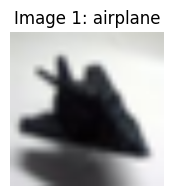

Predicted Category: ship

Processing Image 2 - True Label: automobile


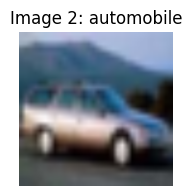

Predicted Category: truck

Processing Image 3 - True Label: bird


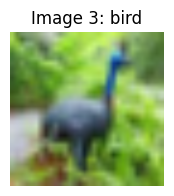

Predicted Category: horse

Processing Image 4 - True Label: cat


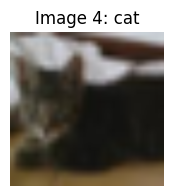

Predicted Category: ship

Processing Image 5 - True Label: deer


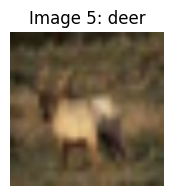

Predicted Category: ship

Processing Image 6 - True Label: dog


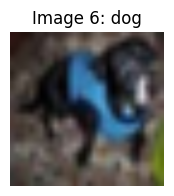

Predicted Category: ship

Processing Image 7 - True Label: frog


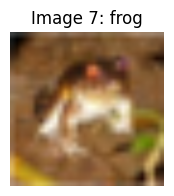

Predicted Category: ship

Processing Image 8 - True Label: horse


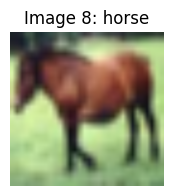

Predicted Category: ship

Processing Image 9 - True Label: ship


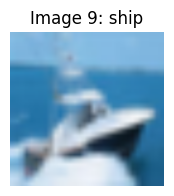

Predicted Category: airplane

Processing Image 10 - True Label: truck


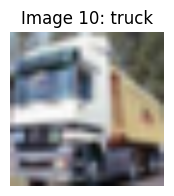

Predicted Category: ship


In [29]:
pipe = setup_pipeline()

categories = dataset.classes  # ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for idx in range(len(images)):
    image_tensor = images[idx]
    true_label = labels[idx]
    print(f"\nProcessing Image {idx+1} - True Label: {true_label}")

    plt.figure(figsize=(2, 2))
    np_image = image_tensor.numpy().transpose((1, 2, 0))
    np_image = (np_image * 0.5) + 0.5
    plt.imshow(np_image)
    plt.axis('off')
    plt.title(f"Image {idx+1}: {true_label}")
    plt.show()
    
    predicted_category = zero_shot_classify(image_tensor, categories, pipe)

    print(f"Predicted Category: {predicted_category}")


## Final Function

Finally, we define the `TTI_zero_shot_classify` function to encapsulate all the methods defined in our pipeline and perform zero-shot classification on an input image using a text-to-image diffusion model. This function takes in the image path and a list of classes as inputs, processes the image, and returns the predicted category.

In [30]:
def TTI_zero_shot_classify(image_path, classes):
    
    """
    Parameters:
        image_path (str): The file path to the input image.
        classes (list): A list of class names (strings) to classify the image into.

    Returns:
        str: The predicted category.
    """
    
    pipeline = setup_pipeline()
    img = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.Resize((512, 512)), transforms.ToTensor(), transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    input_tensor = transform(img)
    predicted_category = zero_shot_classify(input_tensor, classes, pipeline)

    return predicted_category


Test Usage

Saving dog.jpg to dog.jpg


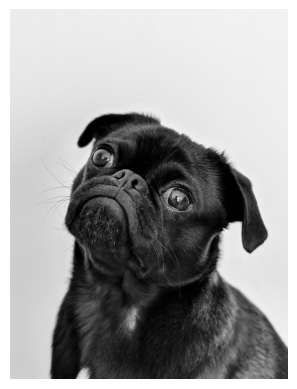

In [31]:
uploaded = files.upload()

img = Image.open('dog.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()


In [32]:
classes = ['cat', 'dog', 'frog', 'horse', 'elephant']

prediction = TTI_zero_shot_classify('dog.jpg', classes)

print(f"Predicted category: {prediction}")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Predicted category: dog


# Fin.